# Part 5 - Creating the Model

So for doing the semantic segmentation I will generate a basic U-net based design and then add in various additional design elements and experiment to see what gives me the best results.

Sources for loss functions - 

focal loss <br/>
https://github.com/mkocabas/focal-loss-keras/blob/master/focal_loss.py

other loss <br/>
https://www.kaggle.com/jonnedtc/cnn-segmentation-connected-components

fixed loss <br/>
https://angusg.com/writing/2016/12/28/optimizing-iou-semantic-segmentation.html

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import warnings
import pydicom

#Import previously created functions
from rnsa_funcs import *

import os
import gc
import itertools

#Remove GPUs
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    

#Import Tensorflow
import tensorflow as tf
from tensorflow import set_random_seed


#Import Keras
import keras
from keras import backend as K
from keras import layers
from keras.layers import Activation, ZeroPadding2D, AveragePooling2D, Add, Concatenate, SeparableConv2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Input, DepthwiseConv2D
from keras.layers import GlobalAveragePooling2D, multiply, ZeroPadding2D, MaxPooling2D, Reshape, add, Conv2DTranspose
#from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.models import Sequential, Model
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.models import load_model
from keras.initializers import glorot_uniform
#from keras.models import load_model
from keras_applications.imagenet_utils import _obtain_input_shape 
from keras.callbacks import ModelCheckpoint
from keras import regularizers

#import sklearn
import sklearn as sk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import pickle


%matplotlib inline

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
from skimage.transform import resize, rotate
#import cv2
from skimage.transform import PiecewiseAffineTransform, warp
from skimage.filters import gaussian

Import data and setup paths.

In [3]:
#Configuring to try to prevent OOM errors
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [4]:
#Setup path locations
BASE_PATH = 'G:\Kaggle\RSNA_Comp'
TRAIN_PATH_RAW = 'G:\Kaggle\RSNA_Comp\stage_1_train_images'
TEST_PATH_RAW = 'G:\Kaggle\RSNA_Comp\stage_1_test_images'
TRAIN_PATH_CLEAN = 'G:\Kaggle\RSNA_Comp\\train_image_clean'
TEST_PATH_CLEAN = 'G:\Kaggle\RSNA_Comp\\test_image_clean'
MODEL_PATH = 'G:\Kaggle\RSNA_Comp\\models'

In [5]:
#Import dataframes from csvs
#train_frame = pd.read_csv(os.path.join(TRAIN_PATH_CLEAN, 'train_frame.csv'))
#val_1_frame = pd.read_csv(os.path.join(TRAIN_PATH_CLEAN, 'val_1_frame.csv'))
#val_2_frame = pd.read_csv(os.path.join(TRAIN_PATH_CLEAN, 'val_2_frame.csv'))
#test_frame = pd.read_csv(os.path.join(TEST_PATH_CLEAN, 'test_frame.csv'))
train_labels = pd.read_csv(os.path.join(BASE_PATH, 'stage_1_train_labels.csv'))

#Import new binary frames
train_frame_new = pd.read_csv(os.path.join(TRAIN_PATH_CLEAN, 'train_frame_seg.csv'))
val_1_frame_new = pd.read_csv(os.path.join(TRAIN_PATH_CLEAN, 'val_1_frame_seg.csv'))

#Import train labels for drawing bounding boxes
train_lab_df = pd.read_csv(os.path.join(TRAIN_PATH_CLEAN, 'train_lab_df.csv'))
val_1_lab_df = pd.read_csv(os.path.join(TRAIN_PATH_CLEAN, 'val_1_labels_tf.csv'))

In [6]:
full_labels = train_lab_df.copy()
full_labels = full_labels.append(val_1_lab_df)


So first define an external function to do the data transform for testing + validation.

In [7]:
def Input_img_batch_BB_DS(df, label_df, pred = 0):
    #Setup Variables
    m = df.shape[0]
    out_img_batch = np.zeros((m, 256, 256))
    out_img_y = np.zeros((m, 256, 256))
    
    
    for i in range(m) :
        #Splitting patient id out for querying the labels
        patient_id = df.iat[i, 6]
        img_filename = patient_id + '.npy'
        
        img = np.load(os.path.join(TRAIN_PATH_CLEAN, img_filename))
        
        #img2 = resize(img, (224, 224), mode='reflect')

        #Transform image to normalize for model processing
        out_img_batch[i] =  resize(img, (256, 256), mode='reflect')
        
        
        #Getting labels
        if pred == 0 :
                pat_labels = label_df[label_df['patientId'] == patient_id]
                pat_labels = pat_labels.reset_index()
                out_lab = np.zeros((1024, 1024))
            
                for row in pat_labels.iterrows():
                    dat = row[1]
                    x_min = np.around(dat['x']).astype(int)
                    y_min = np.around(dat['y']).astype(int)
                
                    w = np.around(dat['width']).astype(int)
                    h = np.around(dat['height']).astype(int)
                
                    for x in range(w):
                        x_pix = np.clip(x + x_min, 0, 1023)
                        for y in range(h):
                            y_pix = np.clip(y + y_min, 0, 1023)
                            out_lab[y_pix, x_pix] = 1.0
                        
                out_img_y[i] = resize(out_lab, (256, 256), mode='reflect')
        
        

    out_img_batch = out_img_batch.reshape(m, 256, 256, 1)
    #if self.predict:
        #return out_img_batch
   #else :
    out_y = out_img_y.reshape(m, 256, 256, 1)
    return out_img_batch, out_y

Next transform this function into a keras sequence that can be parsed by a model in order to read data from disk and transform on CPU while the model is processing a minibatch on GPU.

I will use image distortion as one form of regularization and the distortions are as follows - 
* Rotation (+- 20 degrees)
* Horizontal flips

I also downscaled the image to 256x256, while this is suboptimal for the top competitors I am limited in GPU memory (8Gb) and I have found that having smaller resolution but larger minibatch sizes outperforms the higher resolution models for my particular setup.

In [45]:
class XRAY_generator_BB_DS(keras.utils.Sequence):
    
    def __init__(self, dataframe,label_df ,  filepath, batch_size=32, shuffle=True, predict=0, distort = 1):
        self.dataframe = dataframe
        self.filepath = filepath
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.labels = None
        self.predict = predict
        self.label_df = label_df
        self.distort = distort
        self.on_epoch_end()

    #------------------
    
    def __get_minibatch(self, batch_num):
        #Get batch info
        m = self.dataframe.shape[0]
        max_batchno = int(np.ceil(len(self.dataframe) / self.batch_size))
        batch_num_act = batch_num % max_batchno
    
        #List container for indices selected
        ind_list = []
    
        #Generate indices to select for this minibatch
        for i in range(self.batch_size):
            j = (batch_num_act*self.batch_size) + i
            if j < m :
                ind_list.append(j)
    
        #Select indices from dataframe
        out_df = self.dataframe.iloc[ind_list]
    
        return out_df
    
    def __Input_img_batch_BB(self, df):
        #Setup Variables
        m = df.shape[0]
        out_img_batch = np.zeros((m, 256, 256))
        out_img_y = np.zeros((m, 256, 256))
    
    
        for i in range(m) :
            #Splitting patient id out for querying the labels
            patient_id = df.iat[i, 6]
            img_filename = patient_id + '.npy'
        
            img = np.load(os.path.join(self.filepath, img_filename))
        
            #img2 = resize(img, (224, 224), mode='reflect')

            #Transform image to normalize for model processing
            out_img_batch[i] = resize(img, (256, 256), mode='reflect')
        
        
            #Getting labels
            if self.predict == 0 :
                pat_labels = self.label_df[self.label_df['patientId'] == patient_id]
                pat_labels = pat_labels.reset_index()
                out_lab = np.zeros((1024, 1024))
            
                for row in pat_labels.iterrows():
                    dat = row[1]
                    x_min = np.around(dat['x']).astype(int)
                    y_min = np.around(dat['y']).astype(int)
                
                    w = np.around(dat['width']).astype(int)
                    h = np.around(dat['height']).astype(int)
                
                    for x in range(w):
                        x_pix = np.clip(x + x_min, 0, 1023)
                        for y in range(h):
                            y_pix = np.clip(y + y_min, 0, 1023)
                            out_lab[y_pix, x_pix] = 1.0
                        
                out_img_y[i] = resize(out_lab, (256, 256), mode='reflect')
        
        
        out_img_batch = out_img_batch.reshape(m, 256, 256, 1)
        if self.predict != 0:
            return out_img_batch
        else :
            out_y = out_img_y.reshape(m, 256, 256, 1)
            return out_img_batch, out_y
        
    def _Gaussian_blur(self, img_in):
        tf_img = gaussian(img_in, sigma=1, output=None, mode='constant', cval=0, 
                          multichannel=None, preserve_range=True, truncate=4.0)
        return tf_img
    
    def _add_gauss_noise(self, image):
        row,col= image.shape
        mean = 0
        var = 0.0005
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col))
        noisy = image + gauss

        return noisy

    def _distort_img(self, df_x, df_y):
        m = df_x.shape[0]
        
        x_dist = np.zeros((m, 256, 256))
        y_dist = np.zeros((m, 256, 256))
        
        for i in range(m) :
            flip_rng = np.random.uniform()
            gauss_rng = np.random.uniform()
            rotate_deg = np.random.uniform(-20, 20)
            
            x_tf = df_x[i, :, :, 0]
            y_tf = df_y[i, :, :, 0]
        
            if flip_rng >= 0.5 :
                x_tf = np.fliplr(x_tf)
                y_tf = np.fliplr(y_tf)
                
            #if gauss_rng <= 0.2 :
                #x_tf = self._Gaussian_blur(x_tf)
            #if gauss_rng <= 0.5 :
            #    x_tf = self._add_gauss_noise(x_tf)
        
            x_tf = rotate(x_tf, rotate_deg, resize=False)
            y_tf = rotate(y_tf, rotate_deg, resize=False)
            
            x_dist[i, :, :] = x_tf
            y_dist[i, :, :] = y_tf
                
  
        x_dist = x_dist.reshape(m, 256, 256, 1)
        y_dist = y_dist.reshape(m, 256, 256, 1)

        return x_dist, y_dist
    
    
    def __Shuffle_DF(self, df):
        shuffled_df = df.reindex(np.random.permutation(df.index))
        shuffled_df = shuffled_df.sort_index()
        return shuffled_df
    
    #------------------

    def __getitem__(self, index):
        # select batch
        mini_batch = self.__get_minibatch(index)
        
        # predict mode: return images and filenames
        if self.predict == 1:
            # load files
            img_array = self.__Input_img_batch_BB(mini_batch)
            
            return img_array
        # train mode: return images and masks
        else:
            # load files
            img_array, Y_true = self.__Input_img_batch_BB(mini_batch)
            
            if self.distort == 1 :
                img_array, Y_true = self._distort_img(img_array, Y_true)
            
            return img_array, Y_true

    def on_epoch_end(self):
        if self.shuffle:
            self.dataframe = self.__Shuffle_DF(self.dataframe)
        
    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))


# Building the Model

So I will loosely base the model upon a U-Net, however after much experimentation I achieved the best results with the below design elements - 

* Vortex Pooling (highest resolution layer only)
* Spacial and Channel Squeeze and Excitation
* DenseBlocks
* Inception Downscaling Blocks
* Elu activation functions

In [9]:
def _resnet_upscale_block(input, filters, k=1, reg = 1e-5):
    ''' Adds a pre-activation resnet block with bottleneck layers
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
        strides: strides of the convolution layer
    Returns: a keras tensor
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    bottleneck_expand = 4

    x = BatchNormalization(axis=channel_axis)(input)
    x = Activation('elu')(x)
    
    x = Conv2DTranspose(filters, (3, 3), strides=(2, 2), padding='same',
                        #kernel_regularizer=regularizers.l2(reg), 
                        dilation_rate=1, use_bias=False)(x)

    # squeeze and excite block
    x = squeeze_excite_block(x)

    return x

In [10]:
#Creating Vortex Pooling Block - Block B from https://arxiv.org/pdf/1804.06242.pdf
#Not the most efficient but block C was annoying to implement
def _Vortex_Pool_Block(input, Filts, rate=(3, 9, 27), input_block = 0):
    #Set Input
    if input_block == 0 :
        x = BatchNormalization(axis=-1)(input)
        x = Activation('elu')(x)
    else :
        x = input
        
    F1 = rate[0]
    F2 = rate[1]
    F3 = rate[2]

    #Path 1
    x1 = Conv2D(Filts, (3, 3), strides=(1, 1), padding='same', 
                #kernel_regularizer=regularizers.l2(r~g), 
                kernel_initializer='he_normal', use_bias=False)(x)
    
    #Path 2    
    x2 = AveragePooling2D(pool_size=(F1, F1), strides=(1, 1), padding='same')(x)
    
    x2 = Conv2D(Filts, (3, 3), strides=(1, 1), padding='same', dilation_rate=(F1, F1), 
                #kernel_regularizer=regularizers.l2(reg), 
                kernel_initializer='he_normal', use_bias=False)(x2)
    
    #Path 3
    x3 = AveragePooling2D(pool_size=(F2, F2), strides=(1, 1), padding='same')(x)
    
    x3 = Conv2D(Filts, (3, 3), strides=(1, 1), padding='same', dilation_rate=(F2, F2),
                #kernel_regularizer=regularizers.l2(reg), 
                kernel_initializer='he_normal', use_bias=False)(x3)
    
    #Path 4
    x4 = AveragePooling2D(pool_size=(F3, F3), strides=(1, 1), padding='same')(x)
    
    x4 = Conv2D(Filts, (3, 3), strides=(1, 1), padding='same', dilation_rate=(F3, F3),
                #kernel_regularizer=regularizers.l2(reg), 
                kernel_initializer='he_normal', use_bias=False)(x4)
    
    
    
    x_out = Concatenate(axis=3)([x1, x2, x3, x4])
    
    x_out = squeeze_excite_block(x_out)
    
    return x_out

In [11]:
#Downscaling Block from inceptionv4
def _Inception_Downscale_Block(input, Filts) : 
    x = BatchNormalization(axis=-1)(input)
    x = Activation('elu')(x)
    
    #Path 1
    x1 = Conv2D(Filts, (3, 3), strides=(2, 2), padding='same', 
                #kernel_regularizer=regularizers.l2(reg), 
                kernel_initializer='he_normal', use_bias=False)(x)
    
    #Path 2    
    x2 = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    #Path 3
    x3 = Conv2D((Filts * 4), (3, 3), strides=(1, 1), padding='same',
                #kernel_regularizer=regularizers.l2(reg), 
                kernel_initializer='he_normal', use_bias=False)(x)
    x3 = Conv2D((Filts * 2), (3, 3), strides=(1, 1), padding='same',
                #kernel_regularizer=regularizers.l2(reg), 
                kernel_initializer='he_normal', use_bias=False)(x3)
    x3 = Conv2D(Filts, (3, 3), strides=(2, 2), padding='same',
                #kernel_regularizer=regularizers.l2(reg), 
                kernel_initializer='he_normal', use_bias=False)(x3)
    
    
    x_out = Concatenate(axis=3)([x1, x2, x3])
    
    x_out = squeeze_excite_block(x_out)
    
    return x_out

Now import all the other functions from SE Resnet.

In [20]:
#Implemented spacial/channel SE as in https://arxiv.org/pdf/1803.02579.pdf
#Note I made 1 minor alteration by introducing a spacial squeeze layer prior to the excitation layer
def squeeze_excite_block(input, ratio=16):
    ''' Create a squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
    Returns: a keras tensor
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init._keras_shape[channel_axis]
    se_shape = (1, 1, filters)

    #Channel SE
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    #Spacial SE - note uncomment below for channel squeeze.
    #Strided seperable conv for spacial squeeze with deconv may be better in future
    #Default is implementation as laid out in original paper
    #spac_se = Conv2D(filters // ratio, (1, 1), activation='relu', padding='same', 
    #                 kernel_initializer='he_normal', use_bias=False)(init)
    spac_se = Conv2D(filters, (1, 1), activation='sigmoid', padding='same', 
                     kernel_initializer='he_normal', use_bias=False)(init) #note change input also
    
    concurrent_se = add([spac_se, se])
    
    
    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, concurrent_se])
    return x




In [173]:
def squeeze_excite_block_old(input, ratio=16):
    ''' Create a squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
    Returns: a keras tensor
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init._keras_shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

In [14]:
def _resnet_bottleneck_block(input, filters, k=1, strides=(1, 1), reg = 1e-5):
    ''' Adds a pre-activation resnet block with bottleneck layers
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
        strides: strides of the convolution layer
    Returns: a keras tensor
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    bottleneck_expand = 4

    x = BatchNormalization(axis=channel_axis)(input)
    x = Activation('elu')(x)

    if strides != (1, 1) or init._keras_shape[channel_axis] != bottleneck_expand * filters * k:
        init = Conv2D(bottleneck_expand * filters * k, (1, 1), padding='same', 
                      kernel_regularizer=regularizers.l2(reg),
                      kernel_initializer='he_normal',
                      use_bias=False, strides=strides)(x)

    x = Conv2D(filters * k, (1, 1), padding='same', 
               kernel_regularizer=regularizers.l2(reg),
               kernel_initializer='he_normal',
               use_bias=False)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('elu')(x)

    x = Conv2D(filters * k, (3, 3), padding='same', 
               kernel_regularizer=regularizers.l2(reg),
               kernel_initializer='he_normal',
               use_bias=False, strides=strides)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('elu')(x)

    x = Conv2D(bottleneck_expand * filters * k, (1, 1), padding='same', 
               kernel_regularizer=regularizers.l2(reg),
               kernel_initializer='he_normal',
               use_bias=False)(x)

    # squeeze and excite block
    x = squeeze_excite_block(x)

    m = add([x, init])
    return m

In [15]:
def __conv_block(ip, nb_filter, bottleneck=False, dropout_rate=None, weight_decay=None):
    x = BatchNormalization(axis=-1)(ip)
    x = Activation('elu')(x)

    if bottleneck:
        inter_channel = nb_filter * 4  # Obtained from https://github.com/liuzhuang13/DenseNet/blob/master/densenet.lua

        x = Conv2D(inter_channel, (1, 1), kernel_initializer='he_normal', padding='same', use_bias=False,
                   #kernel_regularizer=l2(weight_decay)
                  )(x)
        x = BatchNormalization(axis=-1)(x)
        x = Activation('elu')(x)

    x = Conv2D(nb_filter, (3, 3), kernel_initializer='he_normal', padding='same', use_bias=False)(x)
    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


def __dense_block(x, nb_layers, nb_filter, bottleneck=False, dropout_rate=None, weight_decay=None):
    x_in = __conv_block(x, nb_filter, bottleneck, dropout_rate, weight_decay)
    
    x_lay = x_in
    for i in range(nb_layers - 1):
        cb = __conv_block(x_lay, nb_filter, bottleneck, dropout_rate, weight_decay)
        
        x_lay = Concatenate(axis=-1)([x_lay, cb])
        
        
    x = x_lay
    # squeeze and excite block
    x = squeeze_excite_block(x)

    return x

In [16]:
def _resnet_bottleneck_block(input, filters, k=1, strides=(1, 1), reg = 1e-5):
    ''' Adds a pre-activation resnet block with bottleneck layers
    Args:
        input: input tensor
        filters: number of output filters
        k: width factor
        strides: strides of the convolution layer
    Returns: a keras tensor
    '''
    init = input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    bottleneck_expand = 4

    x = BatchNormalization(axis=channel_axis)(input)
    x = Activation('elu')(x)

    if strides != (1, 1) or init._keras_shape[channel_axis] != bottleneck_expand * filters * k:
        init = Conv2D(bottleneck_expand * filters * k, (1, 1), padding='same', 
                      kernel_regularizer=regularizers.l2(reg),
                      kernel_initializer='he_normal',
                      use_bias=False, strides=strides)(x)

    x = Conv2D(filters * k, (1, 1), padding='same', 
               kernel_regularizer=regularizers.l2(reg),
               kernel_initializer='he_normal',
               use_bias=False)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('elu')(x)

    x = Conv2D(filters * k, (3, 3), padding='same', 
               kernel_regularizer=regularizers.l2(reg),
               kernel_initializer='he_normal',
               use_bias=False, strides=strides)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('elu')(x)

    x = Conv2D(bottleneck_expand * filters * k, (1, 1), padding='same', 
               kernel_regularizer=regularizers.l2(reg),
               kernel_initializer='he_normal',
               use_bias=False)(x)

    # squeeze and excite block
    x = squeeze_excite_block(x)

    m = add([x, init])
    return m

In [21]:
def test_block(input_shape = (256, 256, 1)):
    X_input = Input(input_shape)
    
    # block 0 - input
    x_0 = _Vortex_Pool_Block(X_input, 32, input_block =1)
    x = _Inception_Downscale_Block(x_0, 32)
    
    #Block 1 - scale 1
    x_1 = __dense_block(x, 3, 32, False)
    x = _Inception_Downscale_Block(x_1, 32)
    
    #Block 1 - scale 2
    x_2 = __dense_block(x, 4, 64, False)
    x = _Inception_Downscale_Block(x_2, 64)
    
    #Block 2 - scale 3
    x_3 = __dense_block(x, 5, 64, False)
    x = _Inception_Downscale_Block(x_3, 128)
    
    #Block 3 - scale 4
    x_4 = __dense_block(x, 6, 128, False)
    
    #Up Block 0 - scale 3
    x = _resnet_upscale_block(x_4, 128)
    x = Concatenate(axis=3)([x, x_3])
    x = __dense_block(x, 5, 64, False)
    
    #Up Block 1 - scale 2
    x = _resnet_upscale_block(x, 92)
    x = Concatenate(axis=3)([x, x_2])
    x = __dense_block(x, 4, 64, False)
    
    #Up Block 2 - scale 1
    x = _resnet_upscale_block(x, 64)
    x = Concatenate(axis=3)([x, x_1])
    x = __dense_block(x, 3, 32, False)
    
    #Up Block 3 - scale 0
    x = _resnet_upscale_block(x, 64)
    x = Concatenate(axis=3)([x, x_0])
    x = __dense_block(x, 3, 32, False)
    x = _Vortex_Pool_Block(x, 32, input_block =0)
    x = Activation('elu')(x)
    
    x = Conv2D(1, (1, 1), padding='same', kernel_initializer='he_normal')(x)
    
    x_output = Activation('sigmoid')(x)
    
    model = Model(inputs = X_input, outputs = x_output)
    
    return model

In [22]:
test_mod = test_block()

In [23]:
test_mod.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 256, 256, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_5 (AveragePoo (None, 256, 256, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_6 (AveragePoo (None, 256, 256, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (

Note I tried a variety of loss functions including the dice loss and binary cross entropy and various linear combinations, a ratio of 0.6:0.4 seemed to work out best. 

I did try focal variants of dice and BCE and mixtures of focal losses, however they performed worse than their regular counterparts.  I also tried alternative implementations and the below was what I found to work best.

In [ ]:
# define iou loss function
def dice_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    max_true = tf.reduce_max(y_true)
    
    #failsafe in here also
    if max_true == 0 :
        #If no BB do element wise logistic loss
        loss = keras.losses.binary_crossentropy(y_true, y_pred)
    else :
        #Else do DICE loss
        intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
        union = tf.add(tf.reduce_sum(y_true), tf.reduce_sum(y_pred))
        smooth = 1.
        iou = tf.div(tf.add(intersection, smooth),tf.add(tf.subtract(union, intersection), smooth))
        
        loss = tf.subtract(tf.constant(1.0, dtype=tf.float32),iou)
        return loss

# combine bce loss and dice loss
def dice_bce_loss(y_true, y_pred):
    y_true_rs = tf.reshape(y_true, [-1])
    
    max_true = tf.reduce_max(y_true_rs)
    
    if max_true == 0 :
        #If no BB do element wise logistic loss
        return keras.losses.binary_crossentropy(y_true, y_pred)
    else :
        return 0.4 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.6 * dice_loss(y_true, y_pred)
    

In [ ]:
# define iou as a metric
def mean_dice(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    y_pred = tf.round(y_pred)
    
    max_true = tf.reduce_max(y_true)
    
    if max_true == 0 :
        return tf.subtract(1.0, tf.reduce_mean(tf.reduce_sum(y_pred)))
    else :
        intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
        union = tf.add(tf.reduce_sum(y_true), tf.reduce_sum(y_pred))
        smooth = tf.ones(tf.shape(intersection))
        
        iou = tf.div(tf.add(intersection, smooth),tf.add(tf.subtract(union, intersection), smooth))
        return tf.reduce_mean(iou)

In [28]:
test_mod.compile(optimizer = Adam(0.0001), loss = dice_bce_loss, metrics = [mean_dice])

In [46]:
train_gen = XRAY_generator_BB_DS(train_frame_new, full_labels,  TRAIN_PATH_CLEAN, batch_size=4,
                                 shuffle=True, predict=0, distort=1)
#Define validation generator
valid_gen = XRAY_generator_BB_DS(val_1_frame_new,full_labels, TRAIN_PATH_CLEAN, batch_size=4, 
                                 shuffle=True, predict=0, distort=0)

In [41]:
#Define learning rate annealing functions
def lr_annealing(x):
    lr = 0.0001
    return lr*(0.8 ** (x))

In [42]:
learning_rate = tf.keras.callbacks.LearningRateScheduler(lr_annealing)
callbacks_list = [learning_rate]

Run below before fitting for checkpointing.

In [ ]:
# checkpoint
model_name="unetv6.hdf5"
checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH, model_name), monitor='val_loss', verbose=0, save_best_only=True, mode='min')
callbacks_list = [checkpoint, learning_rate]

Often trying to fit by default will cause errors, if this happens initialize all global variables and try again and it will work.

In [33]:
keras.backend.get_session().run(tf.global_variables_initializer())

In [48]:
history = test_mod.fit_generator(train_gen, callbacks=callbacks_list, validation_data=valid_gen,
                                 samples_per_epoch=2000, epochs=160, shuffle=True, initial_epoch = 80)

Epoch 81/160
500/500 [==============================] - 1042s 2s/step - loss: 0.4100 - mean_dice: 0.4785 - val_loss: 0.4227 - val_mean_dice: 0.4619
Epoch 82/160
500/500 [==============================] - 1004s 2s/step - loss: 0.4156 - mean_dice: 0.4710 - val_loss: 0.4282 - val_mean_dice: 0.4417
Epoch 83/160
500/500 [==============================] - 962s 2s/step - loss: 0.4095 - mean_dice: 0.4763 - val_loss: 0.4228 - val_mean_dice: 0.4500
Epoch 84/160
500/500 [==============================] - 967s 2s/step - loss: 0.4141 - mean_dice: 0.4707 - val_loss: 0.4264 - val_mean_dice: 0.4591
Epoch 85/160
500/500 [==============================] - 972s 2s/step - loss: 0.4119 - mean_dice: 0.4728 - val_loss: 0.4389 - val_mean_dice: 0.4458
Epoch 86/160
500/500 [==============================] - 969s 2s/step - loss: 0.4184 - mean_dice: 0.4674 - val_loss: 0.4301 - val_mean_dice: 0.4462
Epoch 87/160
500/500 [==============================] - 976s 2s/step - loss: 0.4070 - mean_dice: 0.4843 - val_loss: 

KeyboardInterrupt: 

Misc functions for loading/saving (if training over multiple sessions).

In [ ]:
#test_mod.save(os.path.join(MODEL_PATH, 'unet_model2.h5'))

In [ ]:
#test_mod = load_model(os.path.join(MODEL_PATH, 'unet_model2.h5'))
#test_mod.load_weights(os.path.join(MODEL_PATH, model_name))

In [34]:
test_mod.load_weights(os.path.join(MODEL_PATH, model_name))

In [49]:
model_name2="unetv6_trained.hdf5"

In [50]:
test_mod.save_weights(os.path.join(MODEL_PATH, model_name2))

In [103]:
#Plotting for fun - I would not recommend this is a beautiful monstrosity.
from keras.utils import plot_model
plot_model(test_mod, to_file='classifier_1.png')

# Predictions

With that out of the way now I need a function to have a look at the predictions and see if the model is actually accurately predicting.

In [36]:
gen_predicts = val_1_frame_new[60:65]
gen_predicts

,Age_Band,PatientsAge,PatientsSex,PixelSpacing,Target,ViewPosition,patientId
60,"(60, 70]",66,M,0.143,0.0,PA,b96b2c1a-37e2-4999-ab30-2f7240c115f5
61,"(30, 40]",34,F,0.168,1.0,AP,3e37afc9-f726-407c-84d0-df382e141721
62,"(50, 60]",60,M,0.139,1.0,AP,bc4f2fce-e1dd-4d50-bdb5-103c25f46c8b
63,"(30, 40]",34,F,0.168,1.0,AP,1636e48a-74eb-48d3-9a84-83f99af0a1fc
64,"(18, 30]",29,M,0.143,0.0,PA,9d2f9b40-61ee-4248-b68b-dfa22567181a


Now to see how it does

In [37]:
out_img_test, out_y_true = Input_img_batch_BB_DS(gen_predicts, full_labels, pred = 0)

In [38]:
pred_gen = XRAY_generator_BB_DS(gen_predicts,None,  TRAIN_PATH_CLEAN, batch_size=1, shuffle=True, predict=1)

In [39]:
predict = test_mod.predict_generator(pred_gen,5)

In [40]:
predict.shape

(5, 256, 256, 1)

Visualizations next. Change imno for simplicity.

In [52]:
imno =3

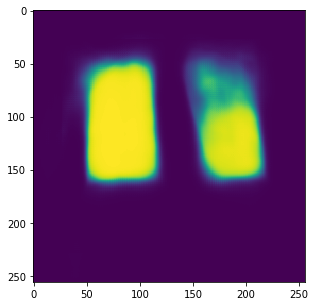

In [53]:
plt.figure(figsize=(5,5))
plt.imshow(predict[imno, :, :, 0])

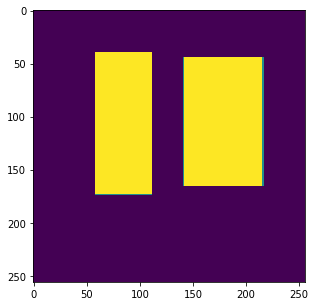

In [54]:
plt.figure(figsize=(5,5))
plt.imshow(out_y_true[imno, :, :, 0])

In [239]:
truth_ls_tf = tf.convert_to_tensor(out_y_true[imno, :, :, 0], np.float32)
pred_ls_tf = tf.convert_to_tensor(predict[imno, :, :, 0], np.float32)

In [240]:
with tf.Session() as test_a:
    tf.global_variables_initializer()
    loss = mean_iou(truth_ls_tf, pred_ls_tf)
    dice = mean_dice(truth_ls_tf, pred_ls_tf)
    print('IoU = ', loss.eval())
    print('Dice = ', dice.eval())

IoU =  0.2408175
Dice =  0.2409049


To see all raw data from one.

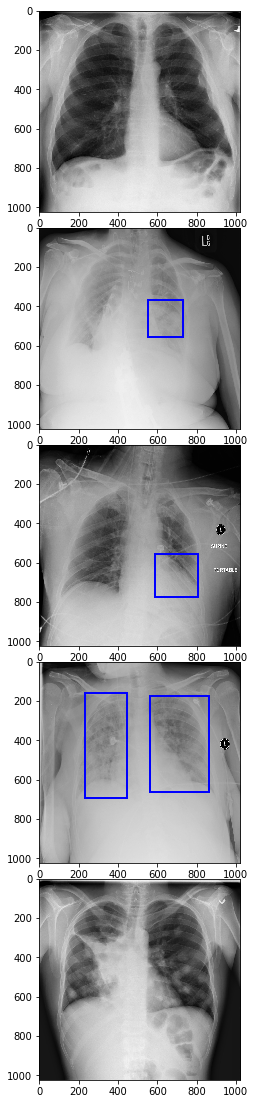

In [212]:
Drawimg_from_DF(gen_predicts, TRAIN_PATH_RAW, train_labels, 15)